In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product

from copy import deepcopy
from tqdm.notebook import tqdm
import ordpy
from scipy.stats import mode, ks_2samp

In [2]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data(p1 = 10., p2 = 28., p3 = 8/3):
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : p1, 'ρ' : p2, 'β' : p3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    x = (x - min(x)) / (max(x) - min(x))
    return x

In [3]:
params = (10., 28., 8/3)

x = get_data(*params)
points_number = x.shape[0]

In [4]:
# Hyper params
L = 4 # length of pattern
K = 10 # maximal value of pattern element

step = 50 # right shift value
M = 10 # iterations number

predicted_points_number = 50

In [5]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

In [6]:
# Compute motives for train_data vector based on train_points number form point start

def fit(train_data, train_points_number, start, current_iter=1, max_iter=1):
    global patterns

    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc=f"Computing matrix of Z-vectors, iteration {current_iter}/{max_iter}", leave=False):
        pattern = patterns[i]
        vecs = []
        for j in range(train_points_number - pattern[-1]):
            vecs.append(train_data[pattern + j + start])
        z_vectors_list.append(np.array(vecs))
    return z_vectors_list

In [7]:
# Normalizing matrix

def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [8]:
# Predictions on train_data based on motives list by predicted_points_number points
# with max_dist between vectors and maximal allowed MAPE max_mape

def predict_with_demon(train_data, motives_list, begin, predicted_points_number, max_dist=0.05, max_mape=0.05):
  global patterns

  x_with_predictions = deepcopy(train_data) # copy of train_data with predictions
  for T in tqdm(range(begin, begin + predicted_points_number), desc="Demon predictions", leave=False):
      St = []
      # for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
      for i in range(patterns.shape[0]):
          for motive in motives_list:
            normalized_predicted = norm(motive[i][:, :-1] - x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]])
            St.extend(motive[i][(normalized_predicted < max_dist), :][:, -1])
      if len(St) == 0:
         predicted_value = np.inf
      else:
         predicted_value = mode(St, keepdims=True).mode[0]
         if abs(predicted_value - train_data[T]) / train_data[T] > max_mape:
            predicted_value = np.inf
      x_with_predictions[T] = predicted_value
  return x_with_predictions[begin : begin + predicted_points_number]

In [9]:
def calculate_metrics(data, begin, train_points_number):
    global x
    
    c, e = [], []
    for i in range(M):
        A = ordpy.complexity_entropy(data[begin + step * i : begin + step * i + train_points_number], dx=5)
        c.append(A[0])
        e.append(A[1])
    return np.mean(np.array(c)), np.mean(np.array(e)), ks_2samp(x, data)

In [10]:
def calculate(train_points_number, y_params_list, begin, max_dist=0.05):
    series = [get_data(*y_params) for y_params in y_params_list]
    series.append(x)

    actual_vals_matrix = []
    predicted_vals_matrix = []

    for i in tqdm(range(M), "Overall iterations loop"):
        start = begin + step * i

        actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
        motives = [fit(arr, train_points_number, start, i + 1, M) for arr in series]
        predicted_vals = predict_with_demon(x, motives, start + train_points_number, predicted_points_number, max_dist)

        actual_vals_matrix.append(actual_vals)
        predicted_vals_matrix.append(predicted_vals)

    actual_vals_matrix = np.array(actual_vals_matrix)
    predicted_vals_matrix = np.array(predicted_vals_matrix)

    loss = np.zeros((predicted_points_number))
    unpredicted_points = np.zeros((predicted_points_number))

    for i in range(M):
        for j in range(predicted_points_number):
            if predicted_vals_matrix[i][j] == np.inf:
                unpredicted_points[j] += 1
            else:
                loss[j] += abs(predicted_vals_matrix[i][j] - actual_vals_matrix[i][j]) * 100 / actual_vals_matrix[i][j]
    loss /= M
    unpredicted_points /= M

    metrics = [calculate_metrics(y, begin, train_points_number) for y in series[:-1]]

    return ((actual_vals_matrix, predicted_vals_matrix), (loss, unpredicted_points), metrics)

In [11]:
def plots(loss, unpredicted_points):
    fig = plt.figure(figsize=(12, 6))
    fig.suptitle(f"Trained on original series + alike series, train_size=1000*5")

    plt.subplot(1, 2, 1)
    plt.title("MAPE, %")
    plt.plot(loss)

    plt.subplot(1, 2, 2)
    plt.ylim((-0.1, 1.1))
    plt.title("Unpredicted points")
    plt.plot(unpredicted_points)

    plt.show()

In [13]:
train_points_number = 1000
begin = 0

First mixing

In [ ]:
mat1 = np.array([
    [0.99, 1., 1.],
    [1., 0.99, 0.98],
    [1.01, 0.98, 1.],
    [1., 1.02, 0.99]
])

data1 = calculate(train_points_number, mat1 * params, begin)

Series (0.99, 1.0, 1.0);           Complexity: 0.5663710348952872, entropy: 0.39349655588011434, Kolmogorov metric: 0.013230769230769268
Series (1.0, 0.99, 0.98);           Complexity: 0.5415473997261195, entropy: 0.3874886780412504, Kolmogorov metric: 0.03346153846153854
Series (1.01, 0.98, 1.0);           Complexity: 0.5547493418971086, entropy: 0.39101814463980583, Kolmogorov metric: 0.02523076923076928
Series (1.0, 1.02, 0.99);           Complexity: 0.5591242782876774, entropy: 0.3945009927483213, Kolmogorov metric: 0.027615384615384597


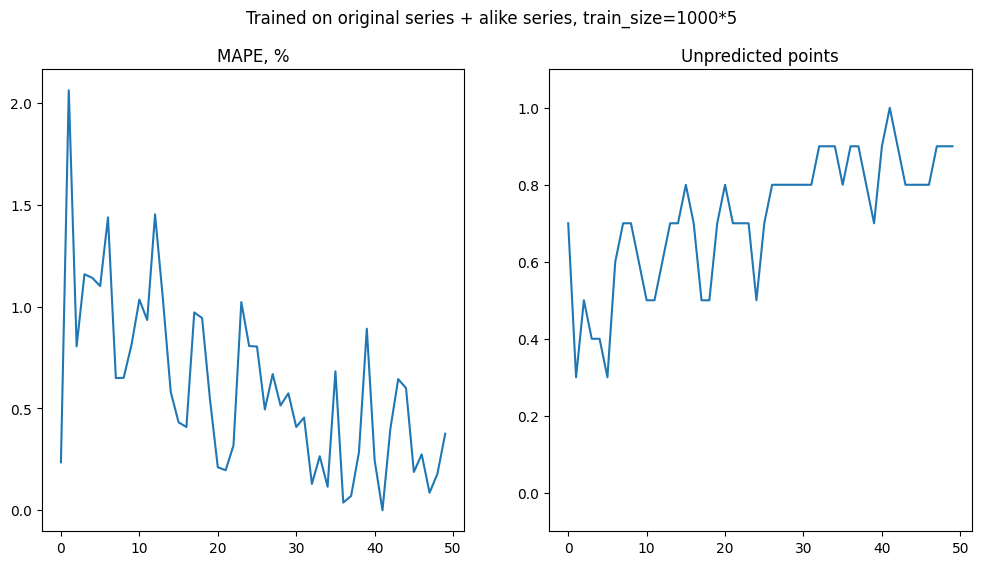

In [57]:
for i in range(len(mat1)):
    print(f"Series ({', '.join(map(str, [round(x, 3) for x in mat1[i]]))});\
           Complexity: {data1[2][i][0]}, entropy: {data1[2][i][1]}, Kolmogorov metric: {data1[2][i][2][0]}")
plots(data1[1][0], data1[1][1])

In [58]:
np.mean(data1[1][1])

0.716

Second mixing

In [ ]:
mat2 = np.array([
    [0.99, 1.02, 0.98],
    [1.0, 1.02, 1.01],
    [1.01, 1.02, 1.02],
    [1.02, 1.02, 0.98]
])

data2 = calculate(train_points_number, mat2 * params, begin)

Series (0.99, 1.02, 0.98);           Complexity: 0.5672041351237606, entropy: 0.3927298644999865, Kolmogorov metric: 0.008846153846153837
Series (1.0, 1.02, 1.01);           Complexity: 0.5660277865051792, entropy: 0.39556929988182626, Kolmogorov metric: 0.009461538461538521
Series (1.01, 1.02, 1.02);           Complexity: 0.5662926913493802, entropy: 0.39681361971786766, Kolmogorov metric: 0.009538461538461496
Series (1.02, 1.02, 0.98);           Complexity: 0.5746005911067595, entropy: 0.3963053472921646, Kolmogorov metric: 0.009538461538461551


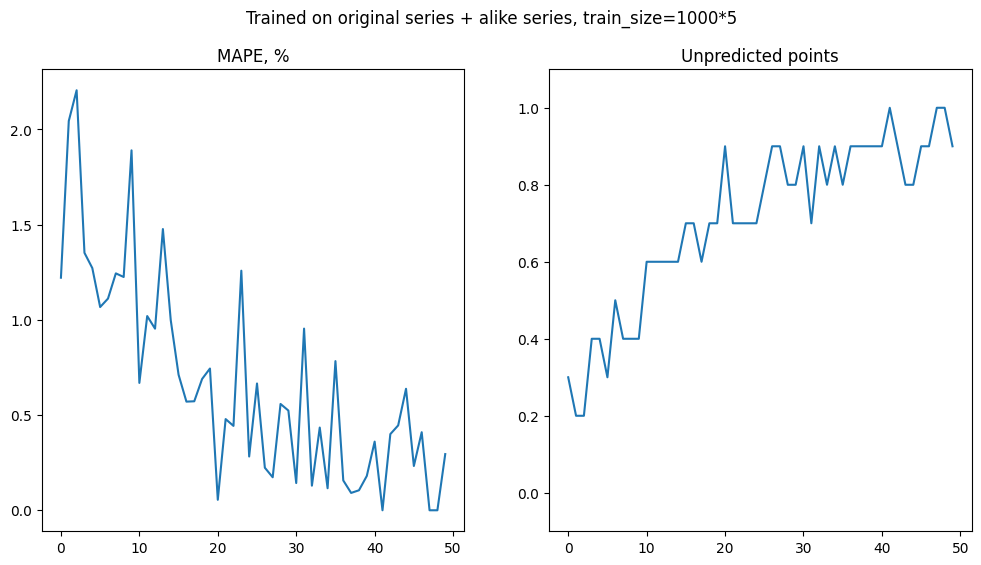

In [78]:
for i in range(len(mat2)):
    print(f"Series ({', '.join(map(str, [round(x, 3) for x in mat2[i]]))});\
           Complexity: {data2[2][i][0]}, entropy: {data2[2][i][1]}, Kolmogorov metric: {data2[2][i][2][0]}")
plots(data2[1][0], data2[1][1])

In [79]:
np.mean(data2[1][1])

0.71

Third mixing

In [ ]:
mat3 = np.array([
    [1.0, 1.02, 1.02],
    [0.99, 1.02, 1.0],
    [0.98, 1.02, 1.0],
    [1.02, 1.0, 1.01]
])

data3 = calculate(train_points_number, mat3 * params, begin)

Series (1.0, 1.02, 1.02);           Complexity: 0.5644016787378079, entropy: 0.3921904952115085, Kolmogorov metric: 0.07023076923076926
Series (0.99, 1.02, 1.0);           Complexity: 0.5514162337678108, entropy: 0.38789465207043927, Kolmogorov metric: 0.07753846153846156
Series (0.98, 1.02, 1.0);           Complexity: 0.5740800796678923, entropy: 0.3973200879518431, Kolmogorov metric: 0.0810769230769231
Series (1.02, 1.0, 1.01);           Complexity: 0.5536449966751861, entropy: 0.38661761203430717, Kolmogorov metric: 0.0948461538461538


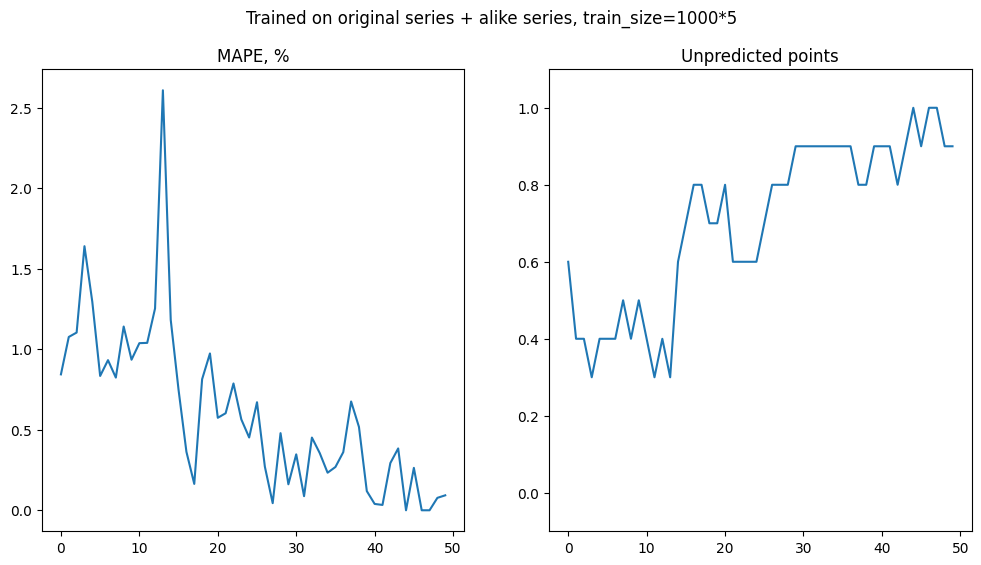

In [82]:
for i in range(len(mat3)):
    print(f"Series ({', '.join(map(str, [round(x, 3) for x in mat3[i]]))});\
           Complexity: {data3[2][i][0]}, entropy: {data3[2][i][1]}, Kolmogorov metric: {data3[2][i][2][0]}")
plots(data3[1][0], data3[1][1])

In [83]:
np.mean(data3[1][1])

0.7040000000000001

Finding closest series

In [5]:
s = []

for p1 in np.linspace(0.98, 1.02, 5):
    for p2 in np.linspace(0.98, 1.02, 5):
        for p3 in np.linspace(0.98, 1.02, 5):
            y_p = get_data(*(params[0] * p1, params[1] * p2, params[2] * p3))
            colm = ks_2samp(x, y_p)[0]
            s.append([colm, p1, p2, p3])

In [6]:
sorted(s)[:10]

[[0.0, 1.0, 1.0, 1.0],
 [0.008846153846153837, 0.99, 1.02, 0.98],
 [0.009461538461538521, 1.0, 1.02, 1.01],
 [0.009538461538461496, 1.01, 1.02, 1.02],
 [0.009538461538461551, 1.02, 1.02, 0.98],
 [0.010692307692307668, 1.02, 1.01, 0.99],
 [0.011230769230769225, 0.99, 0.99, 1.02],
 [0.011307692307692352, 1.01, 1.01, 0.99],
 [0.011846153846153867, 0.98, 1.02, 1.01],
 [0.012153846153846182, 1.02, 0.99, 0.99]]

In [7]:
sorted(s)[-10:]

[[0.059307692307692284, 1.02, 0.98, 0.99],
 [0.0617692307692308, 1.0, 1.01, 0.99],
 [0.0622307692307692, 1.02, 0.99, 0.98],
 [0.06338461538461537, 0.98, 1.0, 1.02],
 [0.0652307692307692, 1.02, 1.01, 0.98],
 [0.0697692307692308, 0.98, 0.98, 0.99],
 [0.07023076923076926, 1.0, 1.02, 1.02],
 [0.07753846153846156, 0.99, 1.02, 1.0],
 [0.0810769230769231, 0.98, 1.02, 1.0],
 [0.0948461538461538, 1.02, 1.0, 1.01]]

Fourth mixing

In [ ]:
mat4 = np.array([
    [1.01, 1.01, 1.02],
    [0.99, 0.99, 1.02],
    [1.01, 0.99, 1.],
    [1.02, 1.01, 0.99]
])

data4 = calculate(train_points_number, mat4 * params, begin)

In [ ]:
plots(train_points_number, data4[2], data4[3])

In [ ]:
print(np.mean(data4[3]))